# James David
Final submission

In [79]:
import statsmodels.api as sma
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn.objects as so
import numpy as np
import pandas as pd
import re
from re import X
from google.colab import drive

drive.mount('/content/drive')
# Edit Path to wherever you store the csv file at
sports_car_df = pd.read_csv('drive/MyDrive/Sport_car_price.csv')

# massage code to make all value to be lowercase - allow easier usage throughout
for column in sports_car_df.columns:
    if sports_car_df[column].dtype == 'object':
        sports_car_df[column] = sports_car_df[column].str.lower()

# creating Engine Type as a copy of Engine Size (L) to be mannipulated later on
sports_car_df["Engine Type"] = sports_car_df["Engine Size (L)"]

sports_car_df.info()
sports_car_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
 8   Engine Type              997 non-null    object
dtypes: int64(1), object(8)
memory usage: 70.9+ KB


,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Type
0,porsche,911,2022,3,379,331,4,"101,200",3
1,lamborghini,huracan,2021,5.2,630,443,2.8,"274,390",5.2
2,ferrari,488 gtb,2022,3.9,661,561,3,"333,750",3.9
3,audi,r8,2022,5.2,562,406,3.2,"142,700",5.2
4,mclaren,720s,2021,4,710,568,2.7,"298,000",4


Code below will show the unique data "sample size" when looking at 'Car Model', 'Engine Size (L)', and 'Horsepower'

In [80]:
car_model_unique_count = sports_car_df['Car Model'].nunique()
engine_size_unique_count = sports_car_df['Engine Size (L)'].nunique()
horse_power_unique_count = sports_car_df['Horsepower'].nunique()
torque_unique_count = sports_car_df['Torque (lb-ft)'].nunique()

print("car_model_unique_count : ", car_model_unique_count )
print("engine_size_unique_count : ", engine_size_unique_count )
print("horse_power_unique_count : ", horse_power_unique_count )
print("torque_unique_count : ", torque_unique_count)

car_model_unique_count :  175
engine_size_unique_count :  45
horse_power_unique_count :  124
torque_unique_count :  93


Massage code so that it can be usable before analyzing and comparing

In [81]:
# Replacing the ',' in the Price (in USD) with nothing
# turning the Price (in USD) into an integer value
sports_car_df['Price (in USD)']=sports_car_df['Price (in USD)'].str.replace(',', '')
sports_car_df['Price (in USD)']=sports_car_df['Price (in USD)'].astype(int)

# added for later purposes
sports_car_df['Torque (lb-ft)']=sports_car_df['Torque (lb-ft)'].str.replace('+', '')
sports_car_df['Torque (lb-ft)']=sports_car_df['Torque (lb-ft)'].str.replace(',', '')
sports_car_df['Torque (lb-ft)']=sports_car_df['Torque (lb-ft)'].str.replace('-', '0')
sports_car_df['0-60 MPH Time (seconds)']=sports_car_df['0-60 MPH Time (seconds)'].str.replace('<', '')

<ipython-input-81-12dc795d0f84>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sports_car_df['Torque (lb-ft)']=sports_car_df['Torque (lb-ft)'].str.replace('+', '')


In [82]:
# Lists out the specific rows within the Engine Size (L) column contain value 'NaN'
sports_car_df[sports_car_df["Engine Size (L)"].isna()]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Type
168,rimac,c_two,2022,NaN,1914,1696,1.9,2400000,NaN
171,tesla,model s plaid,2021,NaN,1020,1050,1.98,131190,NaN
222,porsche,taycan turbo s,2021,NaN,750,774,2.6,185000,NaN
247,tesla,model s plaid,2022,NaN,1020,1050,1.9,131190,NaN
387,rimac,c_two,2022,NaN,1888,1696,1.8,2400000,NaN
389,tesla,roadster,2022,NaN,10000+,0,1.9,200000,NaN
686,rimac,c_two,2022,NaN,1914,1696,1.85,2400000,NaN
697,lotus,evija,2022,NaN,1972,1254,2.5,2700000,NaN
752,porsche,taycan,2022,NaN,469,479,3.8,79900,NaN
916,tesla,roadster,2022,NaN,"10,000+",NaN,1.9,200000,NaN


MINOR DATA INTEGRATION - RESEARCH OF CARS ABOVE TO DETERMINE IF GAS, ELECTRIC, OR HYBRID

Doing external research myself on the cars makes and model that have engine size = NaN,

*   rimac c2 is all electric
*   tesla model s is all electric
*   porsche taycan turbo s is all electric
*   tesla roadster is all electric
*   lotus evija is all electric


With the information investigated above, I can maniupulate the data to replace any NaN values with a value of 0

In [83]:
# With the information investigated above, I can maniupulate the data to replace any NaN values with a value of 0

################################################################
# def : search_engine_type_to_value
# parameters : value
# purpose : for unique cases that column Engine Size (L), the current attribute can be replaced with a value
#           this will allow Engine Size (L) to but utilized in plotting
################################################################
def search_engine_type_to_value(value):
  if re.search(r'\b1.5\b', str(value)):
    return 1.5
  elif re.search(r'\belectric\b', str(value)):
    return 0
  elif re.search(r'\bhybrid\b', str(value)):
    return 1.5
  return value

sports_car_df["Engine Size (L)"] = sports_car_df["Engine Size (L)"].fillna(0)
sports_car_df['Engine Size (L)'] = sports_car_df['Engine Size (L)'].apply(search_engine_type_to_value)
sports_car_df["Engine Size (L)"] = sports_car_df["Engine Size (L)"].replace('-', '0')
sports_car_df["Engine Size (L)"] = sports_car_df["Engine Size (L)"].astype(float)
pd.set_option('display.float_format', '{:.1f}'.format)

#to check tesla	roadster contains 0 for Engine Size (L)
# sports_car_df.info(113)
# sports_car_df.head(113)

In [84]:
################################################################
# def : assign_engine_type
# parameters : value
# purpose : taking the values within Engine Type (cloned initially from Engine Size (L)) and categorizing it among
# engine types : gas, electric, hybrid
################################################################
def assign_engine_type(value):

  # if this string is not not found
  if (str(value).find("1.5 + elect") != -1):
    return 'hybrid'

  # search for string 'hybrid'
  elif re.search(r'\bhybrid\b', str(value)):
    return 'hybrid'

  # search for string 'electric'
  elif re.search(r'\belectric\b', str(value)):
    return 'electric'

  # assign remaining "non unique" cases to gas
  else:
    return 'gas'

# Manipulating original Engine Type to identify Engine Type properly
# utilizing replace and calling assign_engine_type function
sports_car_df["Engine Type"] = sports_car_df["Engine Type"].replace('-', 'electric')
sports_car_df['Engine Type'] = sports_car_df['Engine Type'].apply(assign_engine_type)

# print(sports_car_df["Engine Type"])
# sports_car_df.head(44) # to check specfic case bmw	i8 returns hybrid for engine type

### PLOTS with Analysis

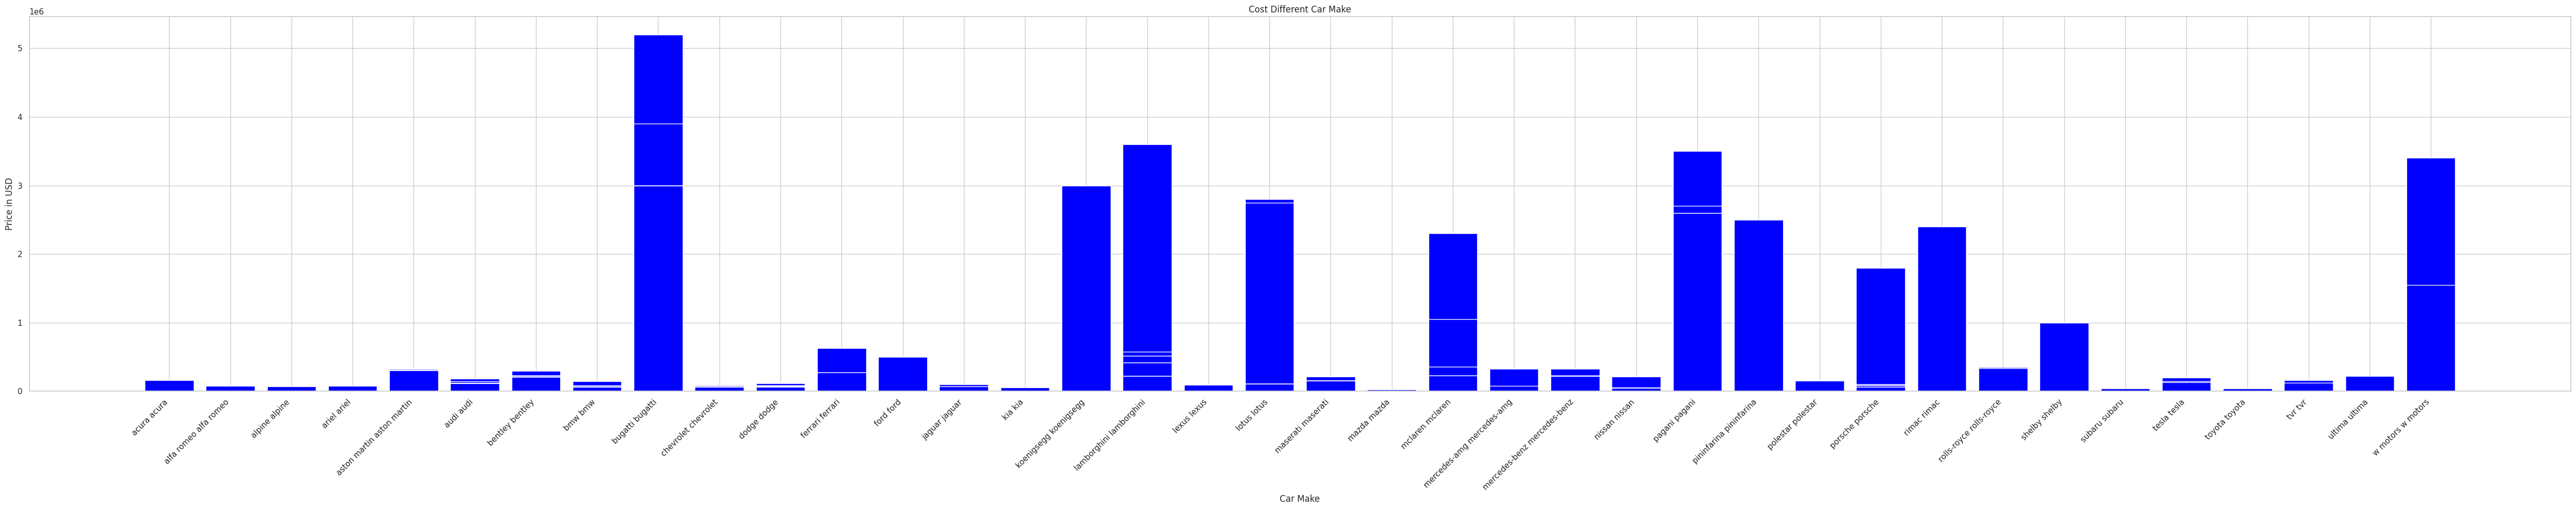

In [85]:
import seaborn as sns

sorted_df = sports_car_df.sort_values(by = 'Car Make')
# Plotting $ per Horsepower
plt.figure(figsize=(50, 10))
plt.bar(sorted_df['Car Make'] + ' ' + sorted_df['Car Make'], sorted_df['Price (in USD)'], color='blue')
plt.xlabel('Car Make')
plt.ylabel('Price in USD')
plt.title('Cost Different Car Make')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

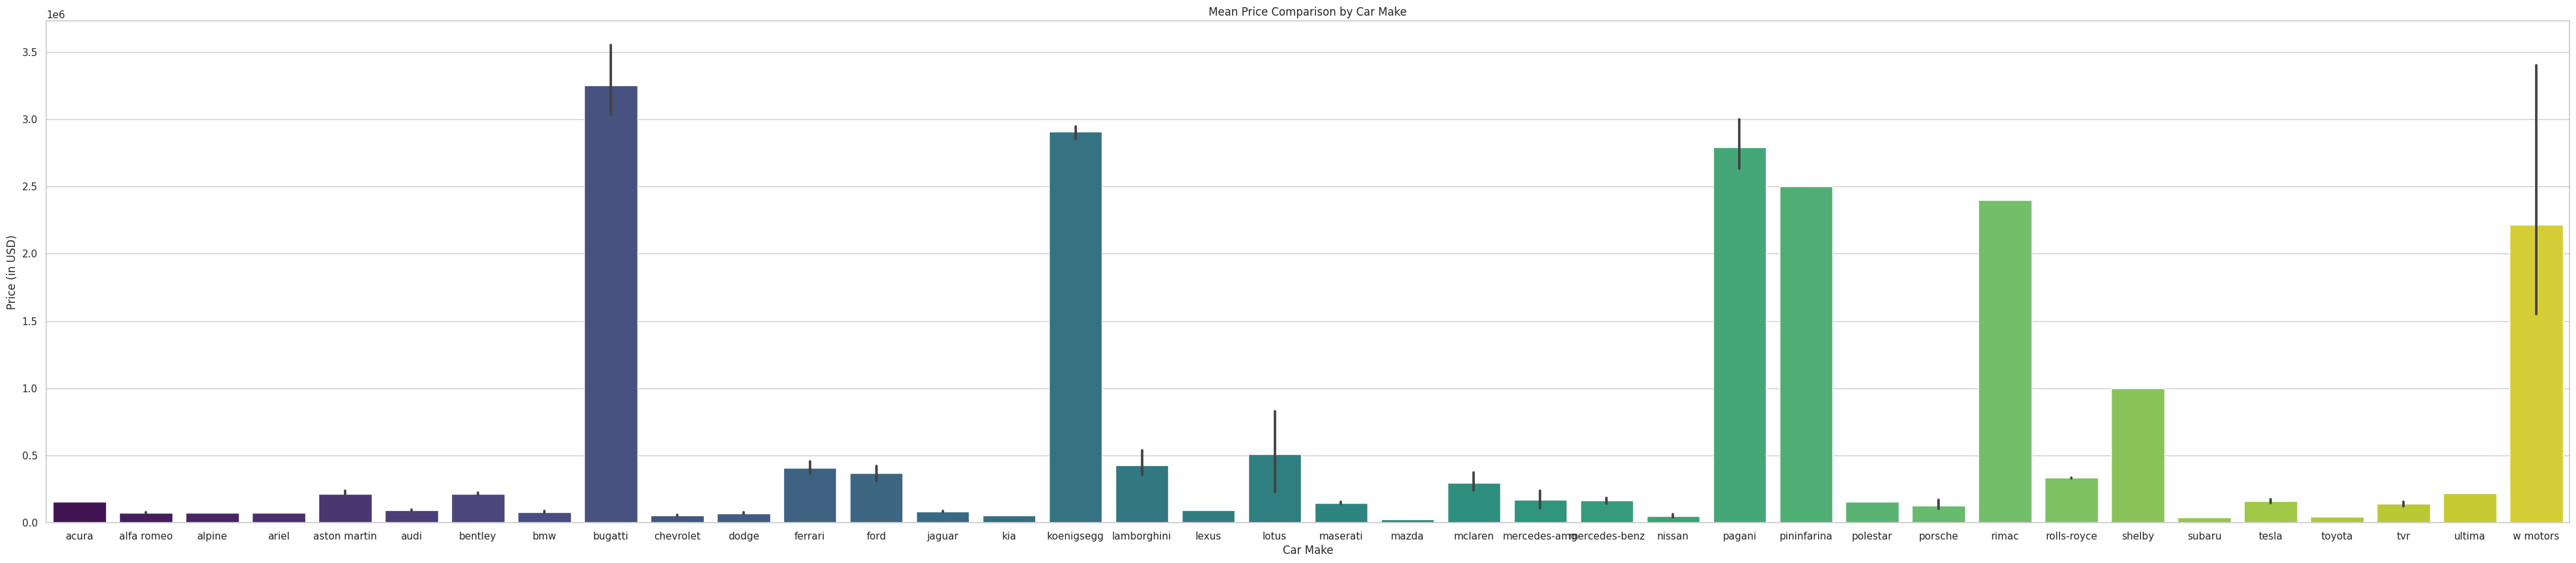

In [86]:
make_mean_prices = sorted_df.groupby('Car Make')['Price (in USD)'].mean().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(50,10))
sns.barplot(x = sorted_df['Car Make'], y = sorted_df['Price (in USD)'], data = make_mean_prices, palette='viridis')

plt.title("Mean Price Comparison by Car Make")
plt.show()

these two plot represents each unique Car Model within the data set and the associated cost.  We can see that out of the unique Car Makes, we can analyze that Bugatti is the most expensive followed by Lambogiuini, Pagani, Koenigsegg, and W Motors. For the least expensive cars, we can say Mazda, Chevrolet, and Kia. These plots is something we keep in mind as we continue with our work since we look for these cars specifically when seeing if their features impact their price.

Total Count of Each Engine Size 
4.0    219
6.2    113
3.0     85
3.5     79
5.0     68
0.0     55
6.5     46
3.8     38
3.7     35
2.0     34
3.9     30
2.9     30
5.2     29
6.0     28
2.5     25
4.7     23
8.0     23
4.4     11
1.5      7
6.8      6
1.7      4
8.4      3
6.6      3
1.8      3
3.6      1
6.3      1
6.4      1
5.7      1
3.3      1
4.6      1
5.5      1
6.7      1
7.0      1
2.3      1
Name: Engine Size (L), dtype: int64


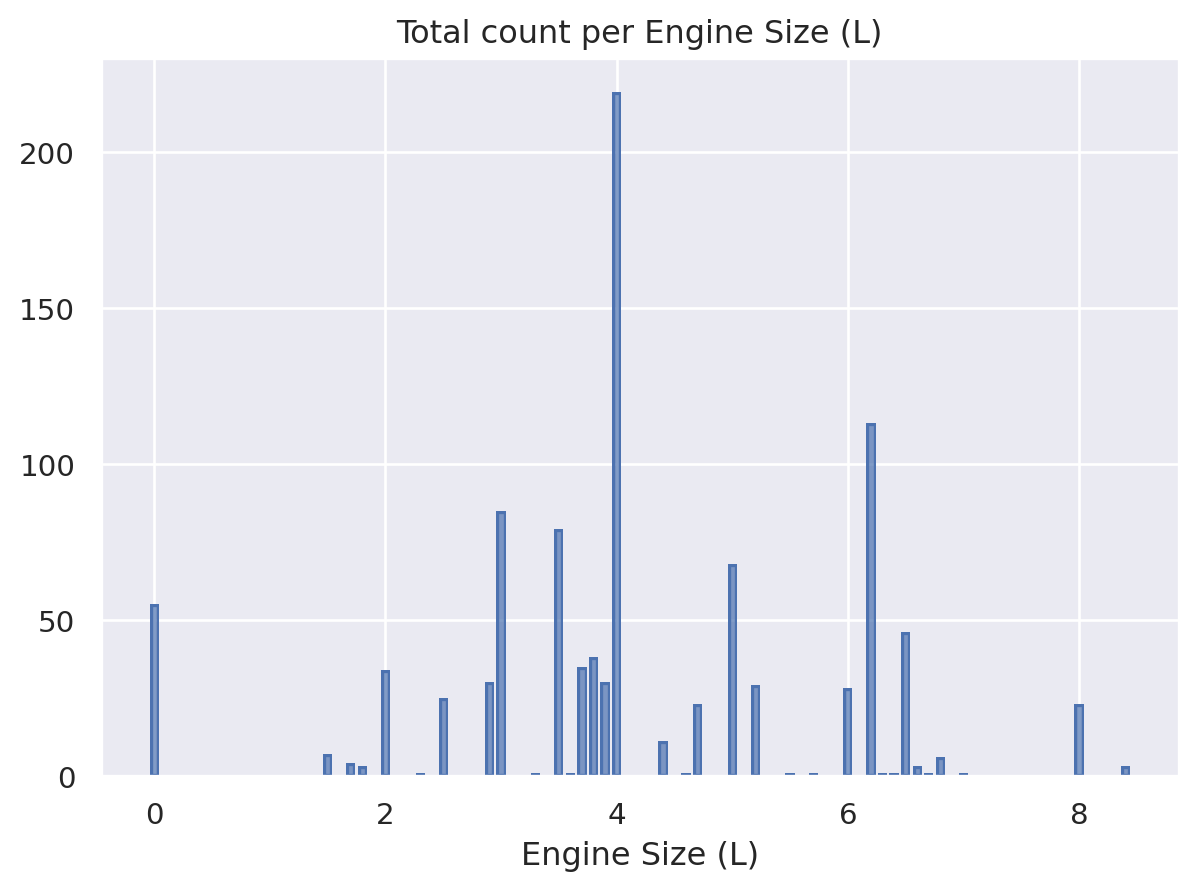

In [87]:
engine_size_count = sports_car_df['Engine Size (L)'].value_counts()
print("Total Count of Each Engine Size ")
print(engine_size_count)

ax = so.Plot(data = sports_car_df, x = 'Engine Size (L)').add(so.Bar(), so.Count())
ax.label(title = "Total count per Engine Size (L)")

This shows the total count of each unique Engine Size (L) to show the sample size of the Engine Size (L)

Text(0.5, 1.0, 'Distribution of Engine Size (L)')

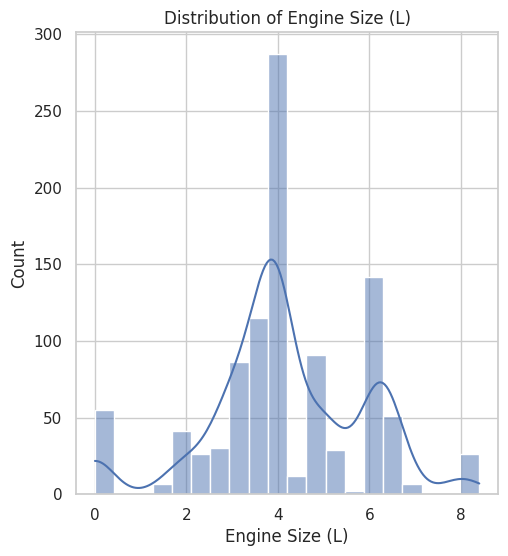

In [88]:
# Distribution Plot of Engine Size
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(sports_car_df['Engine Size (L)'], bins=20, kde=True)
plt.title('Distribution of Engine Size (L)')

This graph is to show the total count of the Engine Size values within the data set. This just helps to undestand the sample size of each Engine Size within the data set.

We can note that there are a little above 50 sports car that have a Engine Size (L) equal to 0. This is because for this data set, there are electric engine type cars that were assigned 0. For the researched cars as explained before, they were filled with 0 since they were also found to be electric.


We can see that within this data set, a large group has a Engine size of 4L. The data ranges from 0 L to no greater than 9L

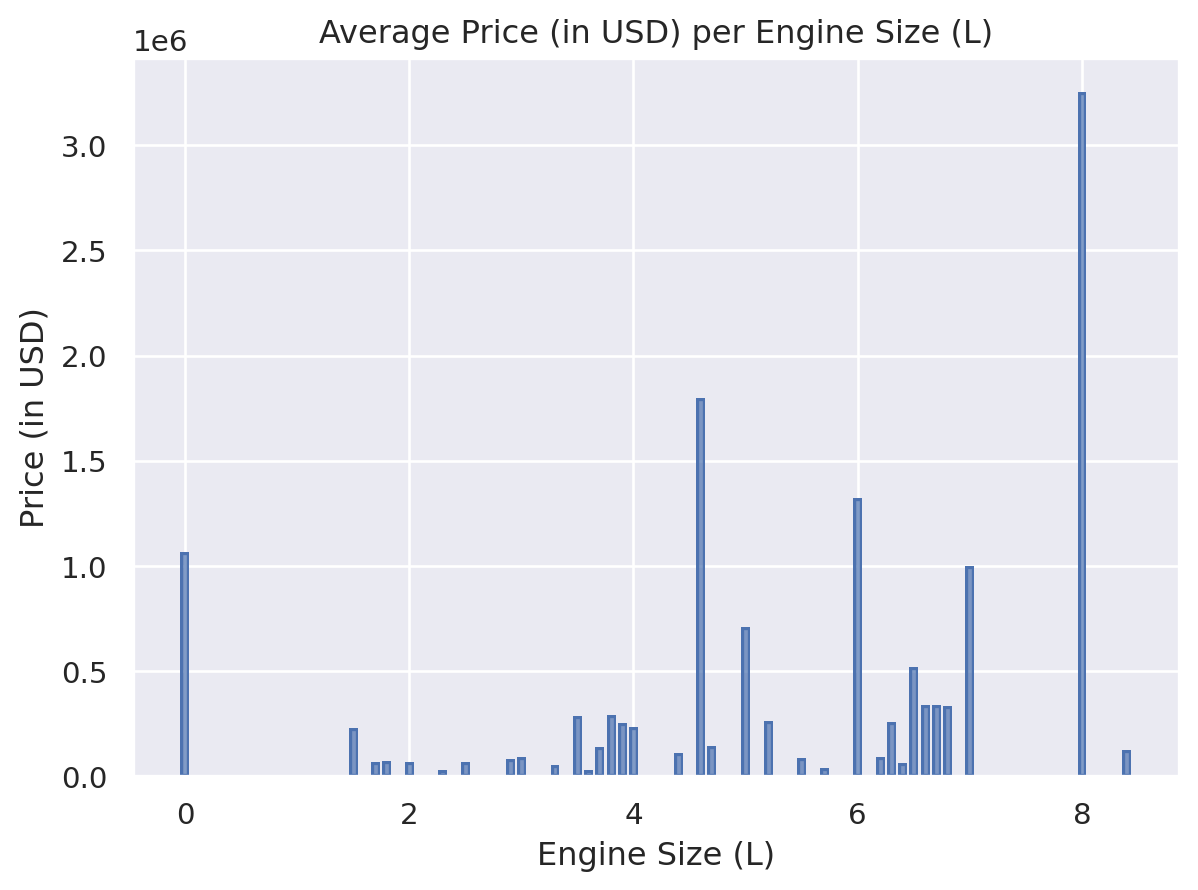

In [89]:
# Creating plot to represent the Average price per engine size ($/L)
ax = so.Plot(sports_car_df['Engine Size (L)'], sports_car_df['Price (in USD)']).add(so.Bar(), so.Agg())
ax.label(title = "Average Price (in USD) per Engine Size (L)")


From this plot, we can identify a few things. There are 34 total unique engine sizes within the data set. Sports Cars within this data set have an Engine Size of 0 L becasue they are electric cars. These electric sports cars look to have a price just above $1,000,000. Looking within the data set, there are a few sports cars under the same car make and model.



The plot represents the Average price per engine size. There shows no trend since there are smaller sample sizes per unique engine size. This sparks a potential idea shown below where we can categorize the Engine Sizes based on ranges. This might provide a better visualization when comparing Engine Size (L) and the Price (in USD).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Car Make                 1007 non-null   object 
 1   Car Model                1007 non-null   object 
 2   Year                     1007 non-null   int64  
 3   Engine Size (L)          1007 non-null   float64
 4   Horsepower               1007 non-null   object 
 5   Torque (lb-ft)           1004 non-null   object 
 6   0-60 MPH Time (seconds)  1007 non-null   object 
 7   Price (in USD)           1007 non-null   int64  
 8   Engine Type              1007 non-null   object 
 9   Engine Size Range        1007 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 78.8+ KB
Total Count of Each Engine Size based on Ranges 
3.5-4.4     334
2.5-3.4     195
5.5-6.4     190
4.5-5.4     122
1.5-2.4      67
Electric     55
7.5-8.5      26
6.5-7.4      11
0.5-1

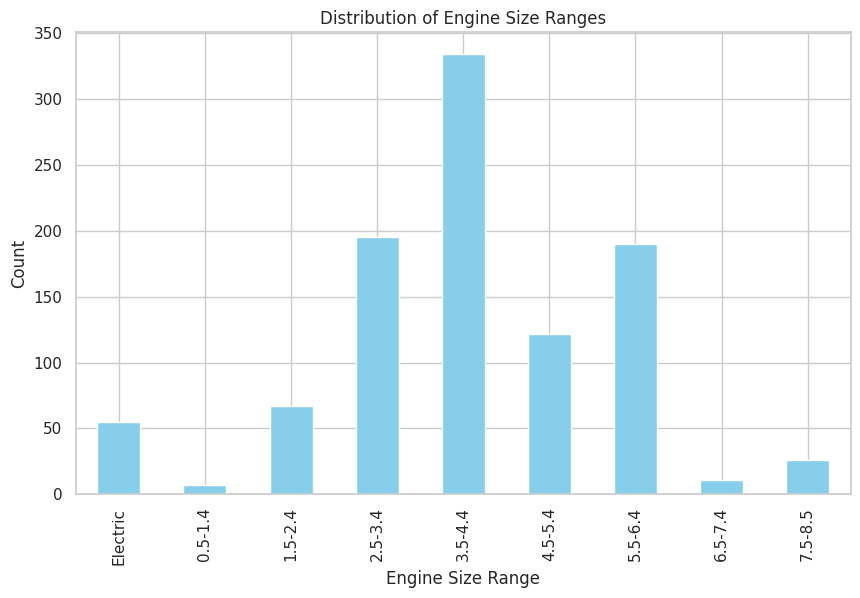

In [90]:
sports_car_df['Engine Size Range'] = sports_car_df['Engine Size (L)']

sports_car_df.info(55)
sports_car_df.head(55)

bins   = [0.0, 0.99, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 9.0]
labels = [0.0, 1.0,  2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0     ]
labels = ['Electric','0.5-1.4','1.5-2.4', '2.5-3.4', '3.5-4.4','4.5-5.4','5.5-6.4','6.5-7.4','7.5-8.5' ]

sports_car_df['Engine Size Range'] = pd.cut(sports_car_df['Engine Size (L)'], bins = bins, labels = labels, include_lowest = True)

engine_size_range_count = sports_car_df['Engine Size Range'].value_counts()
print("Total Count of Each Engine Size based on Ranges ")
print(engine_size_range_count)

plt.figure(figsize=(10, 6))
sports_car_df['Engine Size Range'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Engine Size Ranges')
plt.xlabel('Engine Size Range')
plt.ylabel('Count')
plt.show()



This is the distribution now represented by ranges of engine size. We can still see that the distributio is heavy near the 4.0 L range showing consistency from the previous Engine Size distribution to the Range distribution. This would allow more counts of similar engine sizes to see any potential trends.

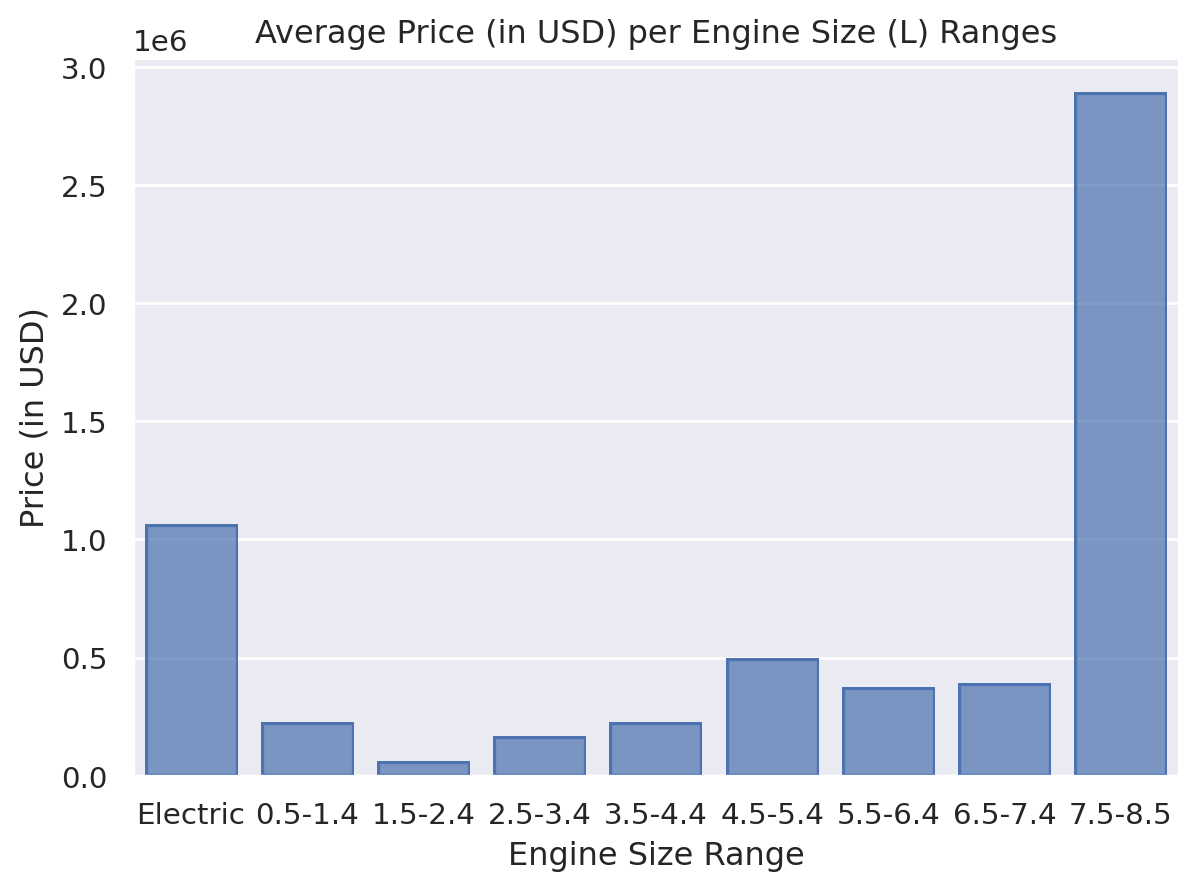

In [91]:
# Creating plot to represent the Average price per engine size ($/L)
ax = so.Plot(sports_car_df['Engine Size Range'], sports_car_df['Price (in USD)']).add(so.Bar(), so.Agg())
ax.label(title = "Average Price (in USD) per Engine Size (L) Ranges")

Here we can see that for an electric sports car is hits an average price a little over 1million USD. are upward trends as the engine sizes increase, so do the prices. There might have been a few cars within the ranges that skew the data in 0.5 L - 1.4 L and 4.5 L - 5.4 L. We think it is fair to make an assumption based on the trend that the Price does increase when a sports car’s engine size is larger.


In [92]:
#highest prices vs engine size
highest_prices_vs_engine_size = sports_car_df[['Car Make', 'Car Model', 'Price (in USD)', 'Engine Size (L)']].nlargest(50, 'Engine Size (L)')
highest_prices = sports_car_df[['Car Make', 'Car Model', 'Price (in USD)', 'Engine Size (L)', 'Engine Type']].nlargest(50, 'Price (in USD)')
print("\nHighest Prices vs Engine Size (L) Values:")
print(highest_prices_vs_engine_size)
print("\nHighest priced cars")
print(highest_prices)

non_zero_engine_size_df = sports_car_df.drop(sports_car_df[sports_car_df['Engine Size (L)'] == 0.0].index)

#lowest prices vs engine size
lowest_prices_vs_engine_size = non_zero_engine_size_df[['Car Make', 'Car Model', 'Price (in USD)', 'Engine Size (L)']].nsmallest(50, 'Engine Size (L)')
lowest_prices = sports_car_df[['Car Make', 'Car Model', 'Price (in USD)', 'Engine Size (L)', 'Engine Type']].nsmallest(50, 'Price (in USD)')
print("\nLowest Prices vs Engine Size (L) Values:")
print(lowest_prices_vs_engine_size)
print("\nLowest priced cars")
print(lowest_prices)



Highest Prices vs Engine Size (L) Values:
         Car Make                Car Model  Price (in USD)  Engine Size (L)
159         dodge                    viper          120000              8.4
369         dodge                    viper          118795              8.4
405         dodge                viper acr          126190              8.4
11        bugatti                   chiron         3000000              8.0
85        bugatti                   chiron         3000000              8.0
113       bugatti                   chiron         3000000              8.0
158       bugatti                   chiron         3000000              8.0
206       bugatti                   chiron         3000000              8.0
274       bugatti                   chiron         2998000              8.0
303       bugatti                   chiron         2998000              8.0
341       bugatti                   chiron         3000000              8.0
376       bugatti                   chiron   

Total Count of Each Engine Type 
gas         958
electric     44
hybrid        5
Name: Engine Type, dtype: int64


Text(0.5, 1.0, 'Mean of Engine Type Prices (in USD)')

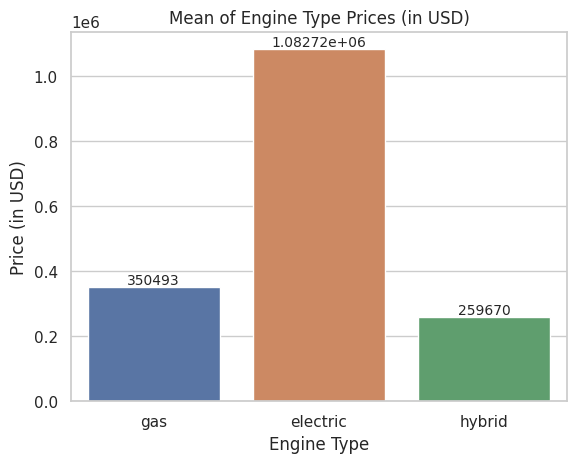

In [93]:
#plot average for engine type vs price

engine_type_count = sports_car_df['Engine Type'].value_counts()
print("Total Count of Each Engine Type ")
print(engine_type_count)


ax = sns.barplot(data = sports_car_df, x = 'Engine Type', y = 'Price (in USD)', errorbar = None)
ax.bar_label(ax.containers[0], fontsize = 10)
ax.set_title("Mean of Engine Type Prices (in USD)")

we thought that this feature would bring important value to see the impact of the sports car’s prices. Due to the lack of cars within the electric or hybrid engine type, it would not be valid to make conclusions. With gas having 958 different cars that are gas, it provides a more accurate representation of the price based on its type. Electric and Hybrid have such a small count and it suggests looking at just a few cars to make a determination of its price. In order to make conclusions per this feature, it would require a much larger and even count sample size for each type. Though this would have been an important feature to see the impact on the prices, we will not utilize this in our conclusions.


In [94]:
# horsepower to engine size
# Explore relationship between horsepower and torque trends when compared to price

# slightly massaging data get rid of extra special characters
sports_car_df['Horsepower']=sports_car_df['Horsepower'].str.replace(',', '')
sports_car_df['Horsepower']=sports_car_df['Horsepower'].str.replace('+', '')
sports_car_df["Engine Size (L)"] = sports_car_df["Engine Size (L)"].astype(int)

# sports_car_df.head(101) # just to verify a special case

<ipython-input-94-d350bcd0e4b3>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sports_car_df['Horsepower']=sports_car_df['Horsepower'].str.replace('+', '')


<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Car Make                 1007 non-null   object  
 1   Car Model                1007 non-null   object  
 2   Year                     1007 non-null   int64   
 3   Engine Size (L)          1007 non-null   int64   
 4   Horsepower               1007 non-null   int64   
 5   Torque (lb-ft)           1004 non-null   object  
 6   0-60 MPH Time (seconds)  1007 non-null   object  
 7   Price (in USD)           1007 non-null   int64   
 8   Engine Type              1007 non-null   object  
 9   Engine Size Range        1007 non-null   category
dtypes: category(1), int64(4), object(5)
memory usage: 72.3+ KB


<Axes: xlabel='Horsepower', ylabel='Price (in USD)'>

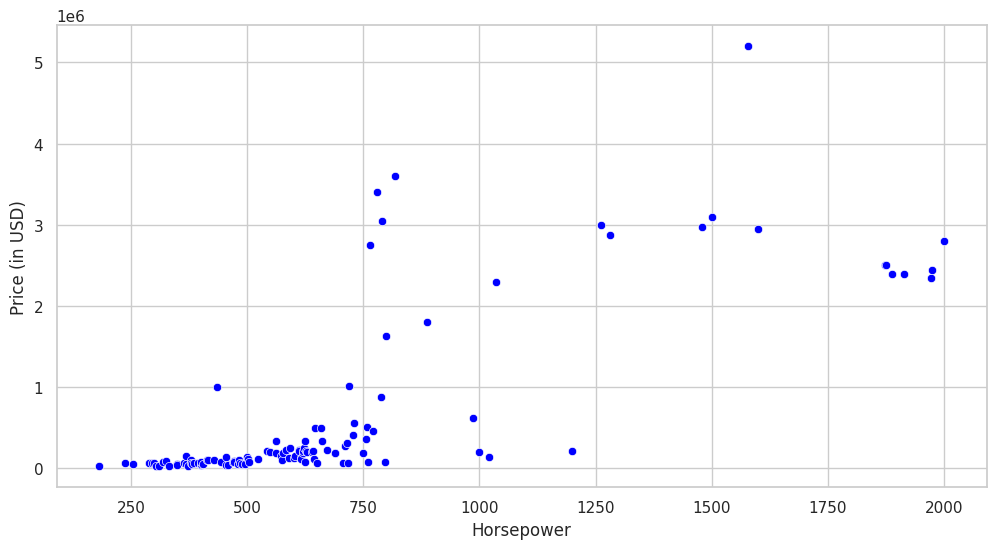

In [95]:
print(type(sports_car_df['Horsepower']))

sports_car_df['Horsepower'] = sports_car_df['Horsepower'].astype(int)

sports_car_df.info()
sports_car_df.head()

horse_power_remove_outlier = sports_car_df.drop(sports_car_df[sports_car_df['Horsepower'] >= 4000].index)

plt.figure(figsize = (12,6))
organized_df = horse_power_remove_outlier.groupby('Horsepower')['Price (in USD)'].mean().reset_index()
sns.scatterplot(data = organized_df, x = "Horsepower", y = "Price (in USD)", color = 'blue')


This scatterplot shows the relationship between Horsepower and Price (in USD). The reason behind this comparison was to see if there are any trends or relationships among the two features.

The plot shows us the impact Horsepower has on the price. We see that there is a distinct upward trend within the 250-750 horsepower range meaning, as the horsepower increases, so does the price. From 750 - 2000 horsepower, we lack the amount of data points to show a trend but we do notice that the prices do increase as the horsepower increases. If there were more data within the data set, we would expect a much more obvious trend throughout the range 0-2000 horsepower. Based on this figure and the analysis we made, we are confident to say that as the car’s horsepower value increases, so does the price in USD.


In [96]:
# Feature Engineering to create a new analysis of the cost per horsepower for the given sports cars
sports_car_df['$ per Horsepower'] = sports_car_df['Price (in USD)'].astype(float) / sports_car_df['Horsepower'].astype(float)

sports_car_df.info()
sports_car_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Car Make                 1007 non-null   object  
 1   Car Model                1007 non-null   object  
 2   Year                     1007 non-null   int64   
 3   Engine Size (L)          1007 non-null   int64   
 4   Horsepower               1007 non-null   int64   
 5   Torque (lb-ft)           1004 non-null   object  
 6   0-60 MPH Time (seconds)  1007 non-null   object  
 7   Price (in USD)           1007 non-null   int64   
 8   Engine Type              1007 non-null   object  
 9   Engine Size Range        1007 non-null   category
 10  $ per Horsepower         1007 non-null   float64 
dtypes: category(1), float64(1), int64(4), object(5)
memory usage: 80.1+ KB


,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Type,Engine Size Range,$ per Horsepower
0,porsche,911,2022,3,379,331,4,101200,gas,2.5-3.4,267.0
1,lamborghini,huracan,2021,5,630,443,2.8,274390,gas,4.5-5.4,435.5
2,ferrari,488 gtb,2022,3,661,561,3,333750,gas,3.5-4.4,504.9
3,audi,r8,2022,5,562,406,3.2,142700,gas,4.5-5.4,253.9
4,mclaren,720s,2021,4,710,568,2.7,298000,gas,3.5-4.4,419.7


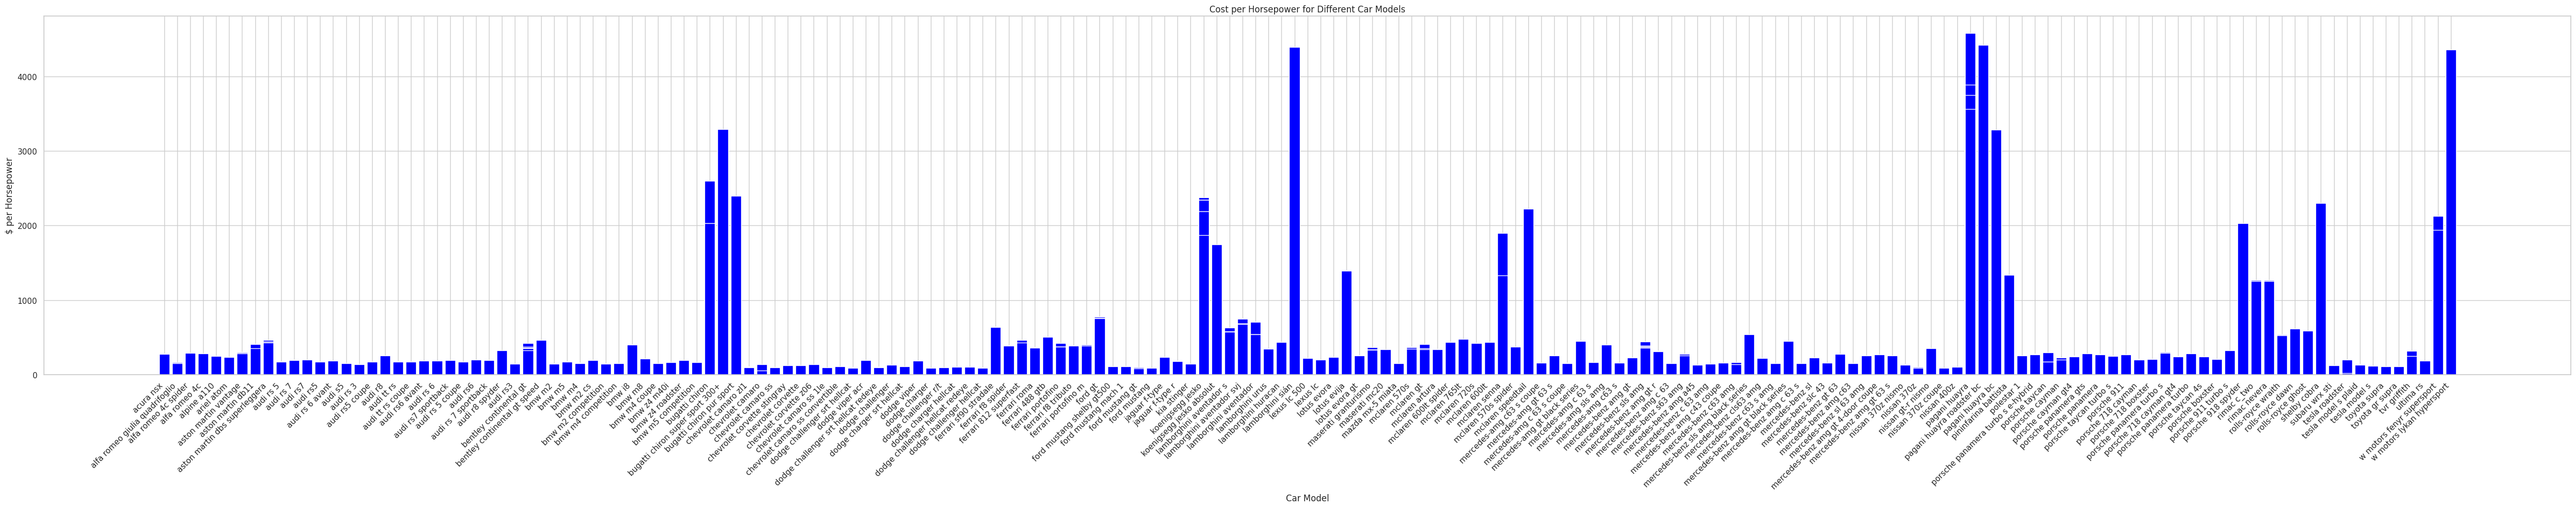

In [97]:
import seaborn as sns

sorted_df = sports_car_df.sort_values(by = 'Car Make')
# Plotting $ per Horsepower
plt.figure(figsize=(50, 10))
plt.bar(sorted_df['Car Make'] + ' ' + sorted_df['Car Model'], sorted_df['$ per Horsepower'], color='blue')
plt.xlabel('Car Model')
plt.ylabel('$ per Horsepower')
plt.title('Cost per Horsepower for Different Car Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

Sorted the data to be in alphabetical order by 'Car Make' to see if there are any sports car of the same make/brand that have similar results that stand out.Using this data plot, we can look at the sports cars that stand out. We can see in this data that the listed bugattis stand out together to have a significant cost per horsepower. We can also look at the lamborguini huracan that has one of the highest cost per horsepower. Pagini brand sports cars look to have the highest cost per horsepower on average. We can conclude that the discussed sports car make and models are the most expensive cars per horspower. This data set does not contain the same amount of each car make so the average of car makes will differ because of the different sample size per car make.

#### Part 2

In [98]:
# mapping of each unique Sports Car Make
car_origin_mapping = {

'acura'         : 'america',
'alfa romeo'    : 'italy',
'alpine'        : 'france',
'ariel'         : 'england',
'aston martin'  : 'england',
'audi'          : 'germany',
'bentley'       : 'england',
'bmw'           : 'germany',
'bugatti'       : 'france',
'chevrolet'     : 'america',
'dodge'         : 'america',
'ferrari'       : 'italy',
'ford'          : 'america',
'jaguar'        : 'england',
'kia'           : 'south korea',
'koenigsegg'    : 'sweden',
'lamborghini'   : 'italy',
'lexus'         : 'japan',
'lotus'         : 'england',
'maserati'      : 'italy',
'mazda'         : 'japan',
'mclaren'       : 'england',
'mercedes-amg'  : 'germany',
'mercedes-benz' : 'germany',
'nissan'        : 'japan',
'pagani'        : 'italy',
'pininfarina'   : 'italy',
'polestar'      : 'china',
'porsche'       : 'germany',
'rimac'         : 'croatia',
'rolls-royce'   : 'england',
'shelby'        : 'america',
'subaru'        : 'japan',
'tesla'         : 'america',
'toyota'        : 'japan',
'tvr'           : 'england',
'ultima'        : 'england',
'w motors'      : 'lebanon',
}

sports_car_df['Origin'] = sports_car_df['Car Make'].map(car_origin_mapping)

sports_car_df.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Engine Type,Engine Size Range,$ per Horsepower,Origin
0,porsche,911,2022,3,379,331,4,101200,gas,2.5-3.4,267.0,germany
1,lamborghini,huracan,2021,5,630,443,2.8,274390,gas,4.5-5.4,435.5,italy
2,ferrari,488 gtb,2022,3,661,561,3,333750,gas,3.5-4.4,504.9,italy
3,audi,r8,2022,5,562,406,3.2,142700,gas,4.5-5.4,253.9,germany
4,mclaren,720s,2021,4,710,568,2.7,298000,gas,3.5-4.4,419.7,england


one hot encoding/dummies


Total Count of Origins 
germany        287
england        229
america        185
italy          176
japan           72
france          24
sweden          15
croatia         14
lebanon          3
china            1
south korea      1
Name: Origin, dtype: int64


Average Prices of Sports Cars By Origin:
Origin
america        165096
china          155000
croatia       2400000
england        273701
france        3119438
germany        117987
italy          534350
japan           64701
lebanon       2216667
south korea     52200
sweden        2906667
Name: Price (in USD), dtype: float64





<ipython-input-99-acb5cdbf344f>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_sports_by_origin = sports_car_df.groupby('Origin').mean()['Price (in USD)']


<function matplotlib.pyplot.show(close=None, block=None)>

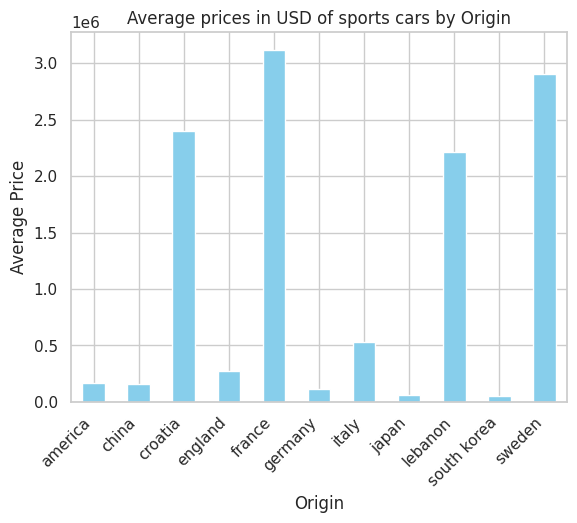

In [99]:
from numpy.ma.extras import average
import pandas as pd
import matplotlib.pyplot as plt

# print(type(sports_car_df))

# One Hot Encode using get_dummies
origin_one_hot = pd.get_dummies(sports_car_df['Origin'], prefix = 'origin')

# concatenate one hot encoded feature with the original dataframe
sports_car_df_2 = pd.concat([sports_car_df, origin_one_hot], axis = 1)

# get average of the price for unique origins
average_sports_by_origin = sports_car_df.groupby('Origin').mean()['Price (in USD)']

pd.set_option('display.float_format', '{:.0f}'.format)

origin_count = sports_car_df_2['Origin'].value_counts()
print("Total Count of Origins ")
print(origin_count)
print("\n")
print("Average Prices of Sports Cars By Origin:")
print(average_sports_by_origin)
print("\n\n")

# print(type(average_sports_by_origin))
average_sports_by_origin.plot(kind = 'bar', rot=0, color = 'skyblue')


plt.title('Average prices in USD of sports cars by Origin')
plt.xlabel('Origin')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

plt.show

This bar grpah shows the newly created feature ‘Origin’ and the average prices of their sports cars. There is a vast range of numbers of cars from their origin country within this data set. Although this may skew some of the values, this plot and information is still important. We can see from the plot in Figure 13 that France has the most expensive sports car price on average, followed by Sweden, Croatia, Lebanon, and Italy. This makes sense to analyze because if we look at the top ~20 most expensive cars, we notice the origin of each are in the list of the top 5 countries we just listed. Through this plot and analysis of the images containing the most expensive and the average country price, we can conclude that the country of origin has an impact on the price of sports cars. Sports cars from specific countries tend to carry a higher price tag.

In [100]:
highest_prices = sports_car_df_2[['Car Make', 'Car Model', 'Price (in USD)', 'Origin']].nlargest(50, 'Price (in USD)')
print("\nHighest priced cars")
print(highest_prices)
lowest_prices = sports_car_df_2[['Car Make', 'Car Model', 'Price (in USD)', 'Origin']].nsmallest(50, 'Price (in USD)')
print("\nLowest priced cars")
print(lowest_prices)


Highest priced cars
         Car Make                Car Model  Price (in USD)   Origin
541       bugatti  chiron super sport 300+         5200000   france
823       bugatti  chiron super sport 300+         5200000   france
983       bugatti                   chiron         3900000   france
438   lamborghini                     sián         3600000    italy
624       bugatti         chiron pur sport         3599000   france
279        pagani       huayra roadster bc         3500000    italy
385        pagani                   huayra         3500000    italy
174      w motors         lykan hypersport         3400000  lebanon
11        bugatti                   chiron         3000000   france
85        bugatti                   chiron         3000000   france
88     koenigsegg                    jesko         3000000   sweden
113       bugatti                   chiron         3000000   france
158       bugatti                   chiron         3000000   france
161    koenigsegg          

This is to just list out the most expensive priced cars and to show its respected origin country. As said before we see that France has the most expensive sports car price on average, followed by Sweden, Croatia, Lebanon, and Italy. This with the plot and the list above provided, we can see consistency with the results. The most expensive cars come from the countries that have the most expensive sports car on average.



In [101]:
highest_prices = sports_car_df_2[['Car Make', 'Origin', 'Price (in USD)']].nlargest(50, 'Price (in USD)')
print("\nHighest priced cars")
print(highest_prices)
lowest_prices = sports_car_df_2[['Car Make','Origin', 'Price (in USD)']].nsmallest(50, 'Price (in USD)')
print("\nLowest priced cars")
print(lowest_prices)


Highest priced cars
         Car Make   Origin  Price (in USD)
541       bugatti   france         5200000
823       bugatti   france         5200000
983       bugatti   france         3900000
438   lamborghini    italy         3600000
624       bugatti   france         3599000
279        pagani    italy         3500000
385        pagani    italy         3500000
174      w motors  lebanon         3400000
11        bugatti   france         3000000
85        bugatti   france         3000000
88     koenigsegg   sweden         3000000
113       bugatti   france         3000000
158       bugatti   france         3000000
161    koenigsegg   sweden         3000000
206       bugatti   france         3000000
275    koenigsegg   sweden         3000000
328    koenigsegg   sweden         3000000
341       bugatti   france         3000000
376       bugatti   france         3000000
434       bugatti   france         3000000
435    koenigsegg   sweden         3000000
499       bugatti   france       

Get Averages for numeric features



In [102]:
# Plot the average of Horsepower

numeric_features = ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)']
average_numeric_features_df = sports_car_df[numeric_features]

average_numeric_features_df = average_numeric_features_df.astype(float).round(2)
average_numeric_features_df.head()

for feature in average_numeric_features_df:
  average_horsepower = average_numeric_features_df[f'{feature}'].mean()
  print(f'\nAverage {feature} : {average_horsepower}')



Average Engine Size (L) : 3.893743793445879

Average Horsepower : 657.9841112214499

Average Torque (lb-ft) : 559.0129482071713

Average 0-60 MPH Time (seconds) : 3.5134061569016883


The provided weighted scales are based on opinoins on what features are more important when looking for a sports car.

Weights:
1. Horsepower =  0.4
2. engine size (L) =  0.3
3. 0-60MPH Time (seconds) = 0.2
4. torque (lb-ft) = 0.1

Calculation:
Score = Xn,1 * 0.4 + Xn,2 * 0.3 + Xn,3 * 0.2 + Xn,4 * 0.1





In [103]:
# Creating a new data frame of only the numeric features

# sports_car_df.info()
# sports_car_df.head()


numeric_features = ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)']

numeric_features_df = sports_car_df[numeric_features]

numeric_features_df['Torque (lb-ft)']=numeric_features_df['Torque (lb-ft)'].str.replace('+', '')
numeric_features_df['Torque (lb-ft)']=numeric_features_df['Torque (lb-ft)'].str.replace(',', '')
numeric_features_df['Torque (lb-ft)']=numeric_features_df['Torque (lb-ft)'].str.replace('-', '0')
numeric_features_df['0-60 MPH Time (seconds)']=numeric_features_df['0-60 MPH Time (seconds)'].str.replace('<', '')


# numeric_features_df.to_csv('drive/MyDrive/Data_Science_Group_Project_Cars/james_sports_car_test_numerics.csv', index = False) # printing out entire csv file to debug manipulated data for Engine Size (L) and Engine Type

numeric_features_df = numeric_features_df.astype(float)

numeric_features_df.info()
numeric_features_df.head()

feature_weight_dict = {
    'Horsepower'              : 0.4,
    'Engine Size (L)'         : 0.3,
    '0-60 MPH Time (seconds)' : 0.2,
    'Torque (lb-ft)'          : 0.1
    }

valued_sports_car_df = numeric_features_df.apply(pd.to_numeric, errors = 'coerce')

# Creating new feature 'Score'
# calculation for 'Score' feature
valued_sports_car_df['Score'] = sum(valued_sports_car_df[feature] * weight for feature, weight in feature_weight_dict.items())

overall_sports_car_df = pd.concat([sports_car_df, valued_sports_car_df['Score']], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Engine Size (L)          1007 non-null   float64
 1   Horsepower               1007 non-null   float64
 2   Torque (lb-ft)           1004 non-null   float64
 3   0-60 MPH Time (seconds)  1007 non-null   float64
dtypes: float64(4)
memory usage: 31.6 KB


<ipython-input-103-3b25d8ddf052>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  numeric_features_df['Torque (lb-ft)']=numeric_features_df['Torque (lb-ft)'].str.replace('+', '')
<ipython-input-103-3b25d8ddf052>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_features_df['Torque (lb-ft)']=numeric_features_df['Torque (lb-ft)'].str.replace('+', '')
<ipython-input-103-3b25d8ddf052>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [104]:
#highest score
highest_scored_sports_car = overall_sports_car_df[['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)','Price (in USD)', 'Score']].nlargest(50, 'Score')
print("\nHighest Scored Sports Car Based of theoretical Weighted Features:\n")
print(highest_scored_sports_car)
# Highest Price
highest_prices = overall_sports_car_df[['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)','Price (in USD)', 'Score']].nlargest(50, 'Price (in USD)')
print("\nHighest Priced Sports Car")
print(highest_prices)


#lowest score
lowest_scored_sports_car = overall_sports_car_df[['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)','Price (in USD)', 'Score']].nsmallest(10, 'Score')
print("\nLowest Scored Sports Car Based of theoretical Weighted Features:")
print(lowest_scored_sports_car)

lowest_prices = overall_sports_car_df[['Car Make', 'Car Model', 'Year', 'Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)','Price (in USD)', 'Score']].nsmallest(5, 'Price (in USD)')
print("\nLowest Priced Sports Car")
print(lowest_prices)




Highest Scored Sports Car Based of theoretical Weighted Features:

         Car Make                Car Model  Year  Engine Size (L)  Horsepower  \
885         tesla                 roadster  2022                0       10000   
389         tesla                 roadster  2022                0       10000   
354         tesla                 roadster  2022                0        1000   
278         rimac                    c_two  2022                0        1914   
439         rimac                    c_two  2021                0        1914   
97          rimac                   nevera  2022                0        1914   
168         rimac                    c_two  2022                0        1914   
509         rimac                    c_two  2021                0        1914   
526         rimac                    c_two  2022                0        1914   
640         rimac                   nevera  2021                0        1914   
26          rimac                   never

We understand that the weight of importance of these features would be different per person asked. A common trend we noticed was that many of the highest scored sports cars are in the list of highest priced sports cars. A common theme is that the highest priced cars have a horsepower higher than 1200 Horsepower. Since horsepower was weighted with the highest importance, we notice that the highest scored cars were the ones with the highest horsepower within the data set. This would result differently if we were to change the weight if the opinion of importance was changed. While this shows trends for a specific set of opinion on priorities, it does provide a list that serves as a useful guidline and reference when looking at the impact of the features.